In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# --- 1. CONFIGURATION DU CHEMIN ---
# Le notebook est dans "notebook/", les modules dans "src/"
# On ajoute le dossier racine (..) au path pour pouvoir faire "from src..."
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

# --- 2. CRÉATION DU DOSSIER DATA ---
DATA_DIR = os.path.join(project_root, "data")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    print(f"📂 Dossier créé : {DATA_DIR}")
else:
    print(f"📂 Dossier données détecté : {DATA_DIR}")

# --- 3. IMPORTS DES MODULES DU PROJET ---
try:
    # Attention : vérifie si ton fichier s'appelle market_simulator.py ou market_simulators.py
    # D'après ton arborescence, c'est le singulier : market_simulator
    from src.market_simulator import MarketSimulator
    from src.analytics_models import BlackScholesOracle
    print("✅ Imports des modules src réussis !")
except ImportError as e:
    print(f"❌ Erreur d'import : {e}")
    print("Vérifie que les fichiers .py sont bien dans le dossier '../src/'")

# Config graphique
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

📂 Dossier données détecté : /Users/jeenyuhs/Desktop/projet_sauvetage/data
✅ Imports des modules src réussis !


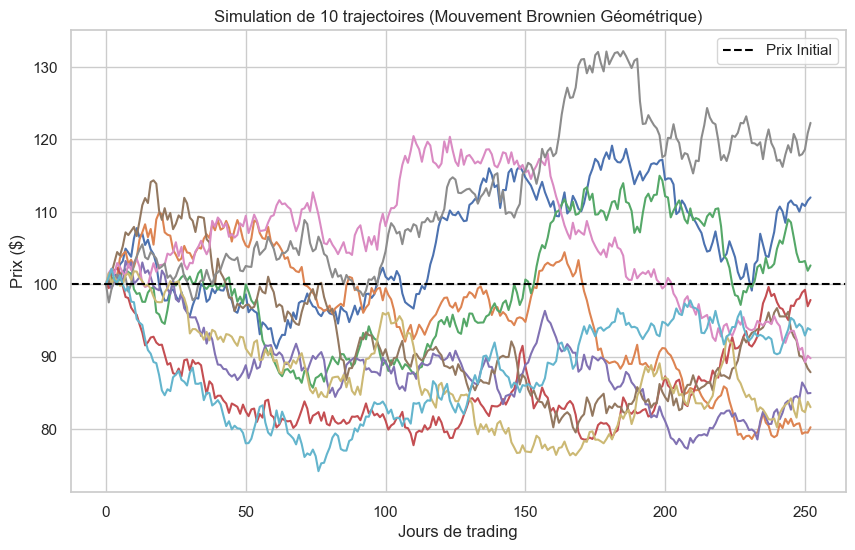

In [5]:
# --- TEST VISUEL : SIMULATEUR DE MARCHÉ (GBM) ---

# Paramètres
S0 = 100       # Prix initial
T = 1.0        # 1 an
N_STEPS = 252  # Jours de bourse
N_PATHS = 10   # Nombre de courbes à afficher

# Instanciation
sim = MarketSimulator(s0=S0, r=0.05, sigma=0.2)

# Génération
paths = sim.simulate_gbm(steps=N_STEPS, n_paths=N_PATHS)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(paths)
plt.title(f"Simulation de {N_PATHS} trajectoires (Mouvement Brownien Géométrique)")
plt.xlabel("Jours de trading")
plt.ylabel("Prix ($)")
plt.axhline(y=S0, color='black', linestyle='--', label="Prix Initial")
plt.legend()
plt.show()

In [6]:
# --- GÉNÉRATION DU DATASET (100 000 SCÉNARIOS) ---

N_SAMPLES = 100000
print(f"🚀 Génération de {N_SAMPLES} options...")

np.random.seed(42) # Reproductibilité

# 1. Inputs aléatoires (X)
S = np.random.uniform(50, 150, N_SAMPLES)      # Spot Price
K = np.random.uniform(50, 150, N_SAMPLES)      # Strike Price
T = np.random.uniform(0.1, 2.0, N_SAMPLES)     # Maturité (années)
r = np.random.uniform(0.01, 0.05, N_SAMPLES)   # Taux (1% - 5%)
sigma = np.random.uniform(0.1, 0.5, N_SAMPLES) # Volatilité (10% - 50%)

# 2. Calcul du Label (Y) avec l'Oracle que tu viens de coder
# On calcule le prix du CALL
calls = BlackScholesOracle.get_price(S, K, T, r, sigma, option_type='call')

# 3. Création du DataFrame
df = pd.DataFrame({
    'S': S, 'K': K, 'T': T, 'r': r, 'sigma': sigma,
    'call_price': calls
})

# Feature Engineering simple (utile pour l'analyse)
df['moneyness'] = df['S'] / df['K']

print("Aperçu des données générées :")
display(df.head())

🚀 Génération de 100000 options...
Aperçu des données générées :


,S,K,T,r,sigma,call_price,moneyness
0,87.454012,108.077904,0.636917,0.016282,0.455581,6.333992,0.809176
1,145.071431,102.697165,0.971486,0.013820,0.226285,44.356329,1.412614
2,123.199394,85.103695,0.288509,0.015518,0.120764,38.475854,1.447639
3,109.865848,99.321266,0.948990,0.028940,0.467898,25.950506,1.106166
4,65.601864,86.509664,0.485855,0.045381,0.274504,0.605967,0.758318


In [7]:
# --- SAUVEGARDE (TRAIN / TEST SPLIT) ---

# Mélange des données
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Séparation 80% / 20%
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Chemins de sauvegarde
train_path = os.path.join(DATA_DIR, "train_data.csv")
test_path = os.path.join(DATA_DIR, "test_data.csv")

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✅ Fichiers sauvegardés avec succès !")
print(f"   Train : {train_path} ({len(train_df)} lignes)")
print(f"   Test  : {test_path} ({len(test_df)} lignes)")

✅ Fichiers sauvegardés avec succès !
   Train : /Users/jeenyuhs/Desktop/projet_sauvetage/data/train_data.csv (80000 lignes)
   Test  : /Users/jeenyuhs/Desktop/projet_sauvetage/data/test_data.csv (20000 lignes)


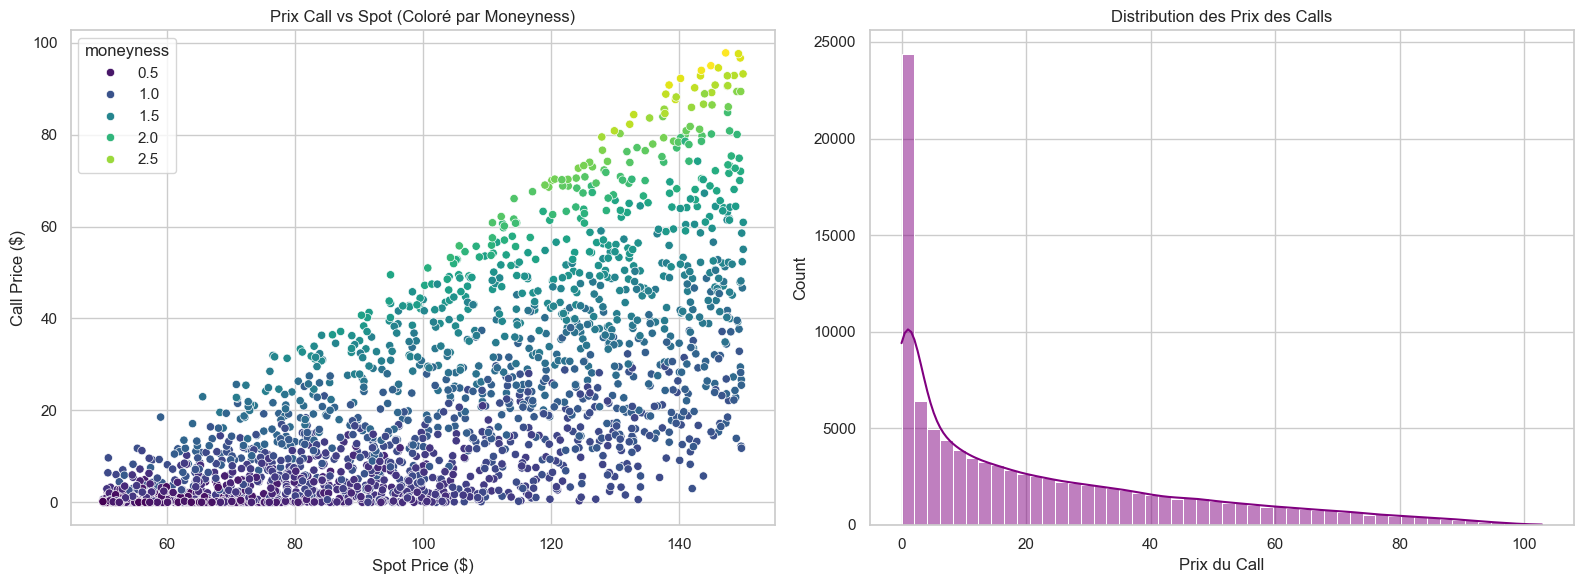

In [8]:
# --- ANALYSE DES DONNÉES GÉNÉRÉES ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Relation Prix Spot vs Prix Option
# On prend un échantillon aléatoire de 2000 points pour ne pas surcharger le graph
sample = df.sample(2000) 
sns.scatterplot(
    data=sample, x='S', y='call_price', 
    hue='moneyness', palette='viridis', ax=axes[0]
)
axes[0].set_title("Prix Call vs Spot (Coloré par Moneyness)")
axes[0].set_xlabel("Spot Price ($)")
axes[0].set_ylabel("Call Price ($)")

# 2. Distribution des prix
sns.histplot(df['call_price'], bins=50, ax=axes[1], color='purple', kde=True)
axes[1].set_title("Distribution des Prix des Calls")
axes[1].set_xlabel("Prix du Call")

plt.tight_layout()
plt.show()